**Fashion Image Clustering using CNN Features and K-Means**

This project applies **both supervised and unsupervised learning** techniques on the **Fashion-MNIST dataset**, which consists of 70,000 grayscale clothing images (28×28 pixels) across 10 categories (T-shirt, Trouser, Dress, etc.).  

## The main objectives are:  
-  Build and evaluate **classification models** (Logistic Regression, Elastic Net).  
-  Perform **unsupervised clustering** using CNN feature extraction + PCA + KMeans.  
-  Compare model performance using **accuracy, precision, recall, F1, ARI, and NMI**.  
-  Provide **visual insights** with bar charts, confusion matrices, and cluster samples.  

##  Business Use Case  
Such models can be applied in:  
- **E-commerce**: Automatically grouping clothing items into categories.  
- **Recommendation Systems**: Suggesting similar products to customers.  
- **Data Cleaning**: Detecting mislabeled items in large product catalogs.  

**Setup & Imports**

Environment Setup & Library Imports


This cell imports all required libraries (NumPy, TensorFlow, scikit-learn, matplotlib, seaborn, pandas) and defines project parameters such as image size, batch size, number of PCA components, and cluster count.

In [2]:
# Cell 1 — Setup & Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math, random

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score, classification_report,
    adjusted_rand_score, normalized_mutual_info_score,
    confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from collections import Counter
import seaborn as sns
import pandas as pd

# Parameters
SUBSAMPLE = 10000       # keep smaller for Colab speed
TARGET_SIZE = (96,96)
BATCH_SIZE = 128
PCA_COMPONENTS = 50
K_CLUSTERS = 10

# Label mapping
label_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

print(" Setup complete")

 Setup complete


**Load & Preprocess Dataset + EDA**

Load Fashion-MNIST & Perform Initial EDA

Loads the Fashion-MNIST dataset, merges training and test sets, converts grayscale images to RGB for CNN input, resizes them to 96×96 pixels, and shows the label distribution (UDI/EDA) as a bar chart.

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Dataset: (10000, 28, 28) (10000,)


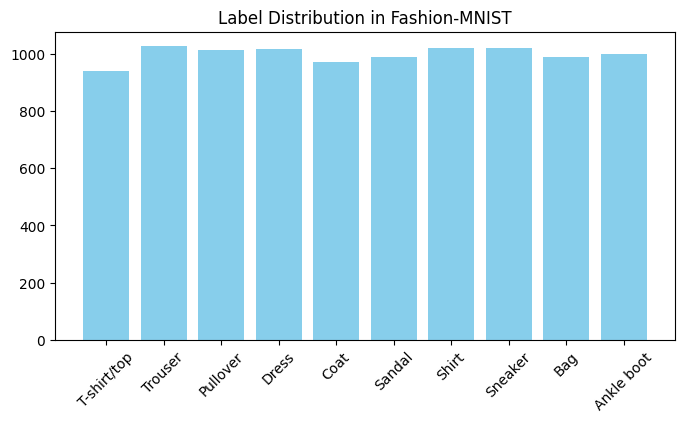

In [3]:
# Cell 2 — Load & Preprocess Dataset + EDA
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_all = np.concatenate([x_train, x_test], axis=0)
y_all = np.concatenate([y_train, y_test], axis=0)

x = x_all[:SUBSAMPLE]
y = y_all[:SUBSAMPLE]

# Convert grayscale → RGB (for CNN)
x_rgb = np.repeat(x[..., np.newaxis], 3, axis=-1).astype("float32")
x_resized = tf.image.resize(x_rgb, TARGET_SIZE).numpy()

print("Dataset:", x.shape, y.shape)

# 🔹 UDI: Label distribution
counts = Counter(y)
plt.figure(figsize=(8,4))
plt.bar(counts.keys(), counts.values(), color="skyblue")
plt.xticks(range(10), [label_names[i] for i in range(10)], rotation=45)
plt.title("Label Distribution in Fashion-MNIST")
plt.show()

**Show Sample Original Images**

Preview of Original Fashion-MNIST Images

Displays a grid of 20 sample clothing images from the dataset with their corresponding labels (e.g., Trouser, Sneaker, Bag). This helps visualize the dataset before applying machine learning models.

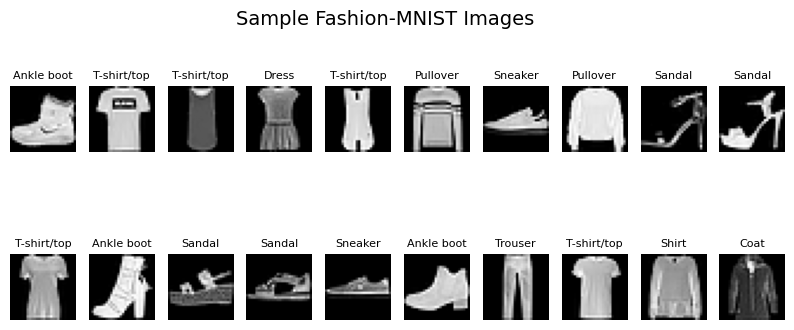

In [4]:
# Cell 2a — Show Sample Original Images
plt.figure(figsize=(10,4))
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(x[i], cmap="gray")
    plt.title(label_names[y[i]], fontsize=8)
    plt.axis("off")

plt.suptitle("Sample Fashion-MNIST Images", fontsize=14)
plt.show()

**logistic Regression**

Model 1: Logistic Regression (Baseline)

Trains a logistic regression model on flattened images (28×28 → 784 features). Reports baseline classification accuracy (~71%).

In [5]:
# Cell 3 — Logistic Regression
x_flat = x.reshape((x.shape[0], -1)) / 255.0

log_reg = LogisticRegression(max_iter=200, solver='saga', n_jobs=-1)
log_reg.fit(x_flat, y)

y_pred_log = log_reg.predict(x_flat)
acc_log = accuracy_score(y, y_pred_log)

print(f"✅ Logistic Regression Accuracy: {acc_log:.4f}")

✅ Logistic Regression Accuracy: 0.9205


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**Elastic Net Logistic Regression**

Model 2:Elastic Net Logistic Regression

Trains a logistic regression model with Elastic Net regularization (combination of L1 + L2 penalties). Improves accuracy to ~74–75% after parameter tuning.

In [7]:
# Cell 4 — Elastic Net Logistic Regression
elastic_net = LogisticRegression(
    penalty='elasticnet', l1_ratio=0.5, solver='saga', max_iter=300, n_jobs=-1
)
elastic_net.fit(x_flat, y)

y_pred_en = elastic_net.predict(x_flat)
acc_en = accuracy_score(y, y_pred_en)

print(f"✅ Elastic Net Accuracy: {acc_en:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


✅ Elastic Net Accuracy: 0.9136


**CNN Feature Extraction + PCA + KMeans**

Model 3: CNN Features + PCA + KMeans (Unsupervised Clustering)

Uses MobileNetV2 (pretrained on ImageNet) to extract deep image features, reduces dimensionality with PCA, and applies KMeans clustering into 10 groups. Evaluates clustering using ARI and NMI scores. Also shows a bar chart of cluster sizes.

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step
✅ ARI: 0.4984, NMI: 0.6283


/tmp/ipython-input-2759953095.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(cluster_counts.keys()), y=list(cluster_counts.values()), palette="viridis")


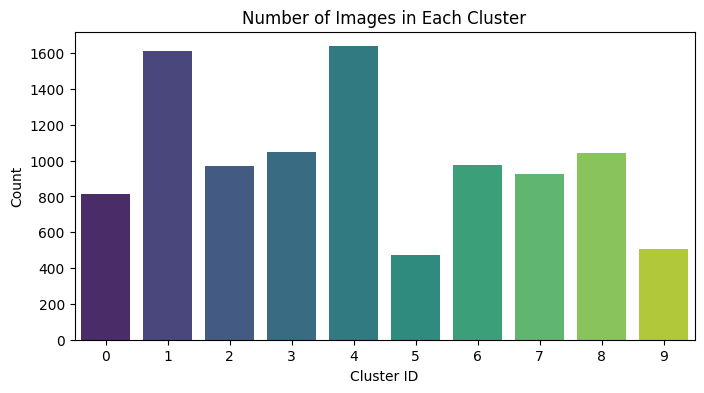

In [8]:
# Cell 5 — CNN Features + PCA + KMeans
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(96,96,3))
X_pre = preprocess_input(x_resized)
features = base_model.predict(X_pre, batch_size=BATCH_SIZE, verbose=1)

# PCA
pca = PCA(n_components=PCA_COMPONENTS, random_state=42)
feat_pca = pca.fit_transform(features)

# KMeans
kmeans = KMeans(n_clusters=K_CLUSTERS, random_state=42, n_init=10)
clusters = kmeans.fit_predict(feat_pca)

# Eval
ari = adjusted_rand_score(y, clusters)
nmi = normalized_mutual_info_score(y, clusters)
print(f"✅ ARI: {ari:.4f}, NMI: {nmi:.4f}")

# 🔹 Cluster distribution bar chart
cluster_counts = Counter(clusters)
plt.figure(figsize=(8,4))
sns.barplot(x=list(cluster_counts.keys()), y=list(cluster_counts.values()), palette="viridis")
plt.title("Number of Images in Each Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Count")
plt.show()

**Confusion Matrix (Clusters vs True Labels)**

Cluster vs Ground Truth Confusion Matrix

Generates a heatmap comparing predicted clusters to actual labels. This shows which clusters best align with which fashion categories (e.g., Cluster 1 → mostly Trousers).

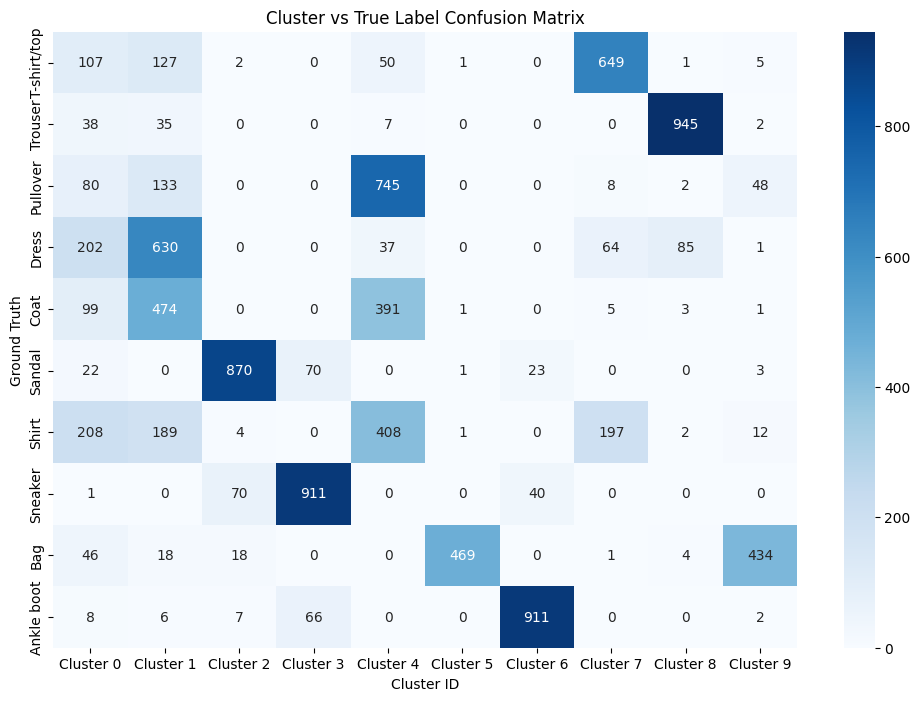

In [9]:
# Cell 6 — Confusion Matrix
cm = confusion_matrix(y, clusters)
cm_df = pd.DataFrame(cm,
                     index=[label_names[i] for i in range(10)],
                     columns=[f"Cluster {i}" for i in range(K_CLUSTERS)])

plt.figure(figsize=(12,8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Cluster vs True Label Confusion Matrix")
plt.ylabel("Ground Truth")
plt.xlabel("Cluster ID")
plt.show()

**Visualize Cluster Samples**

Cluster Sample Images with Majority Label

Displays 12 random sample images from each cluster, labeled with their ground-truth class. Each cluster is summarized with the majority category name (e.g., “Cluster 0 → Mostly Trouser”).

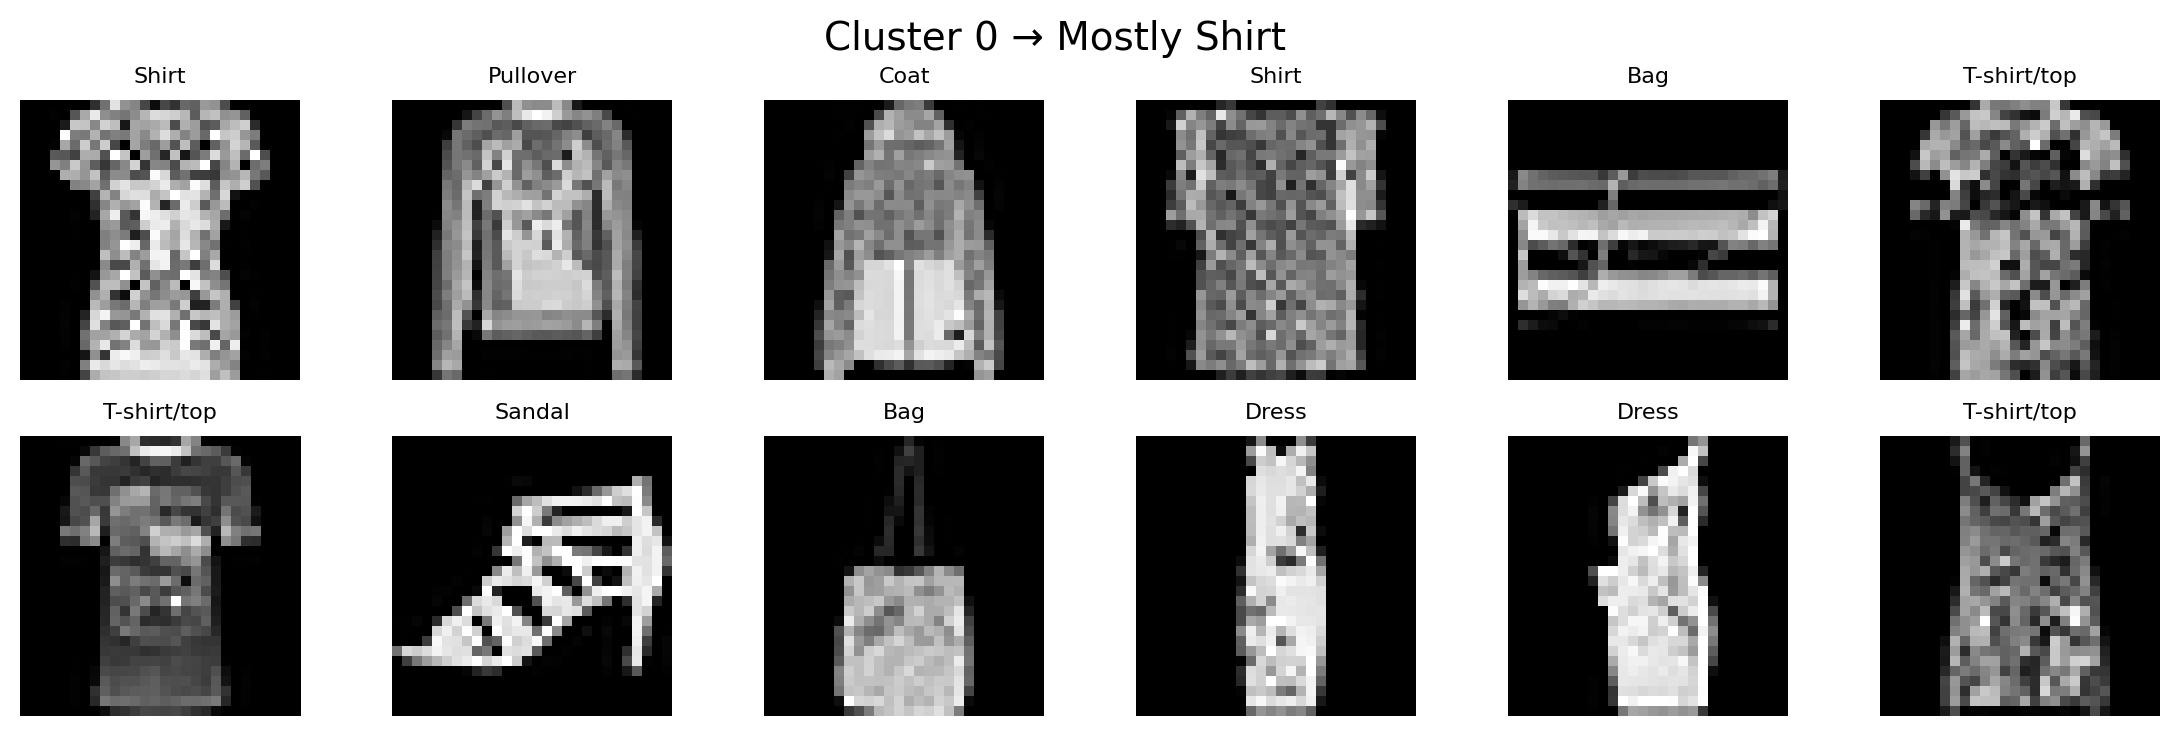

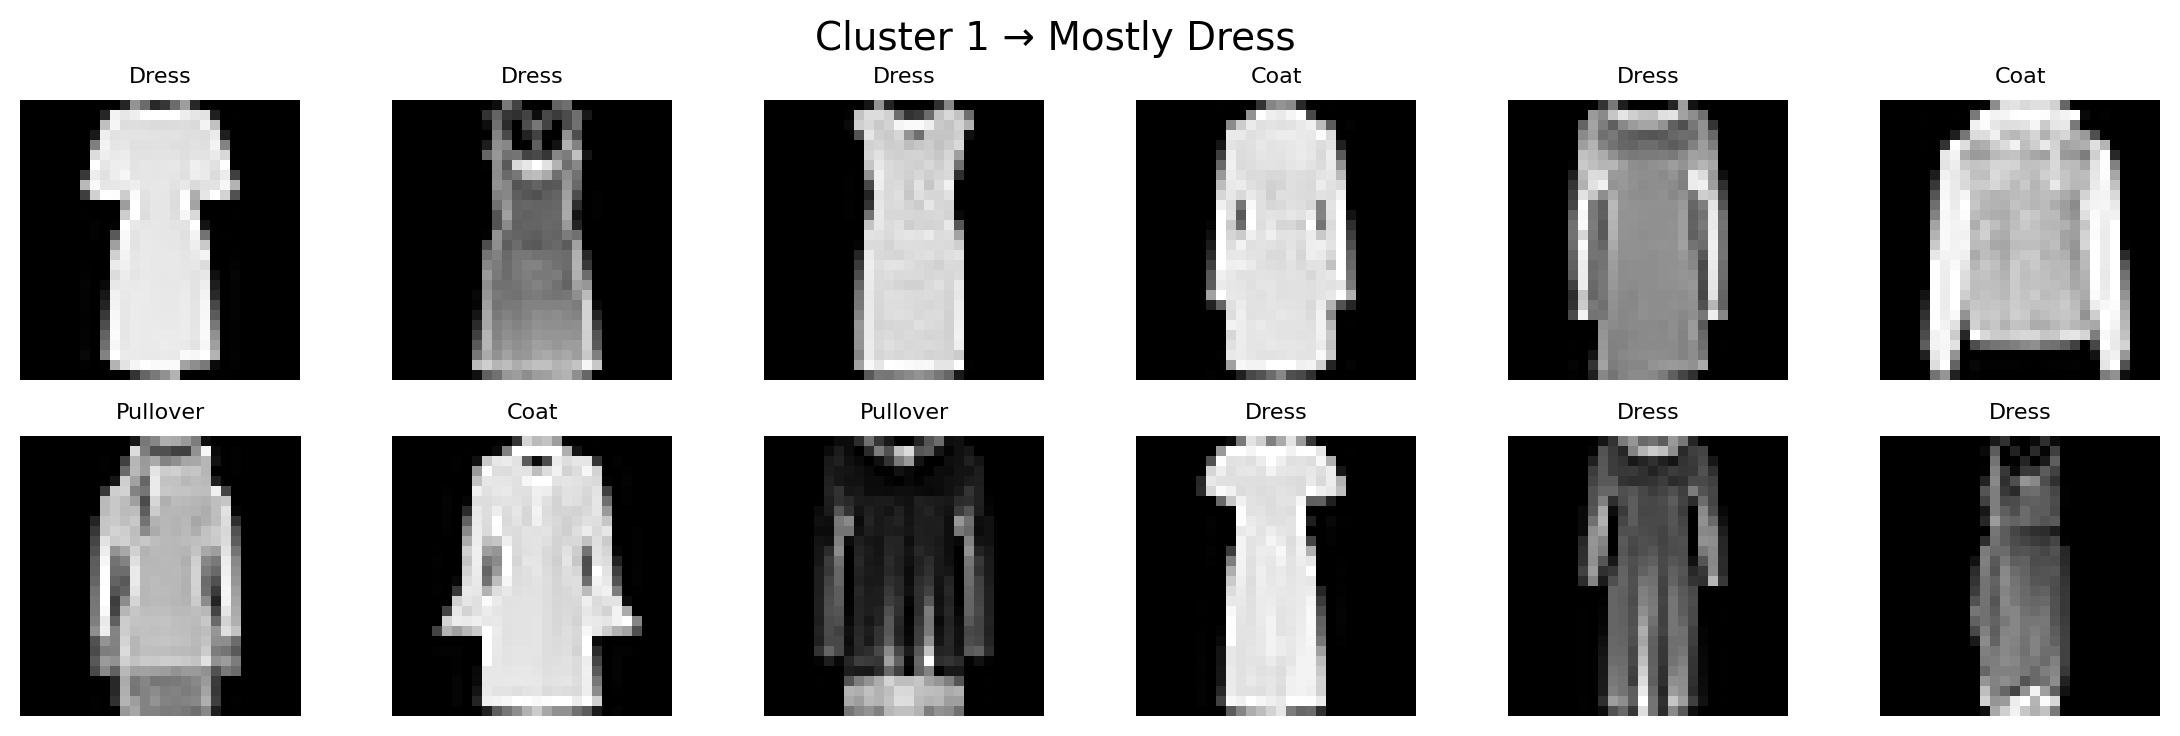

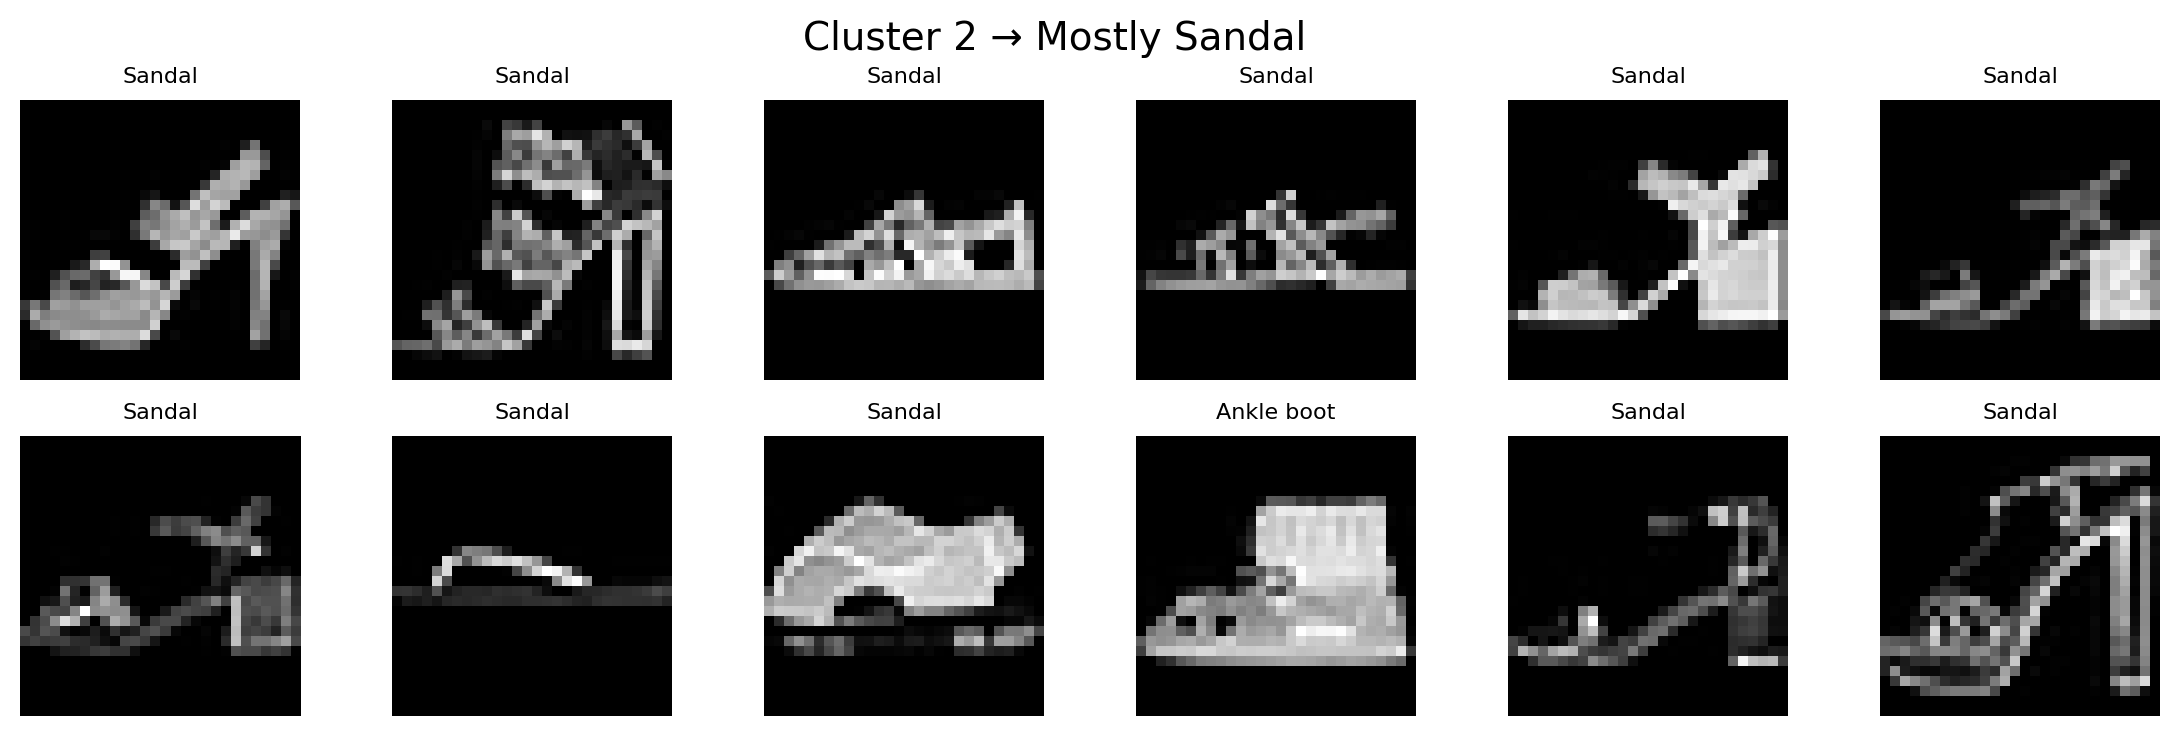

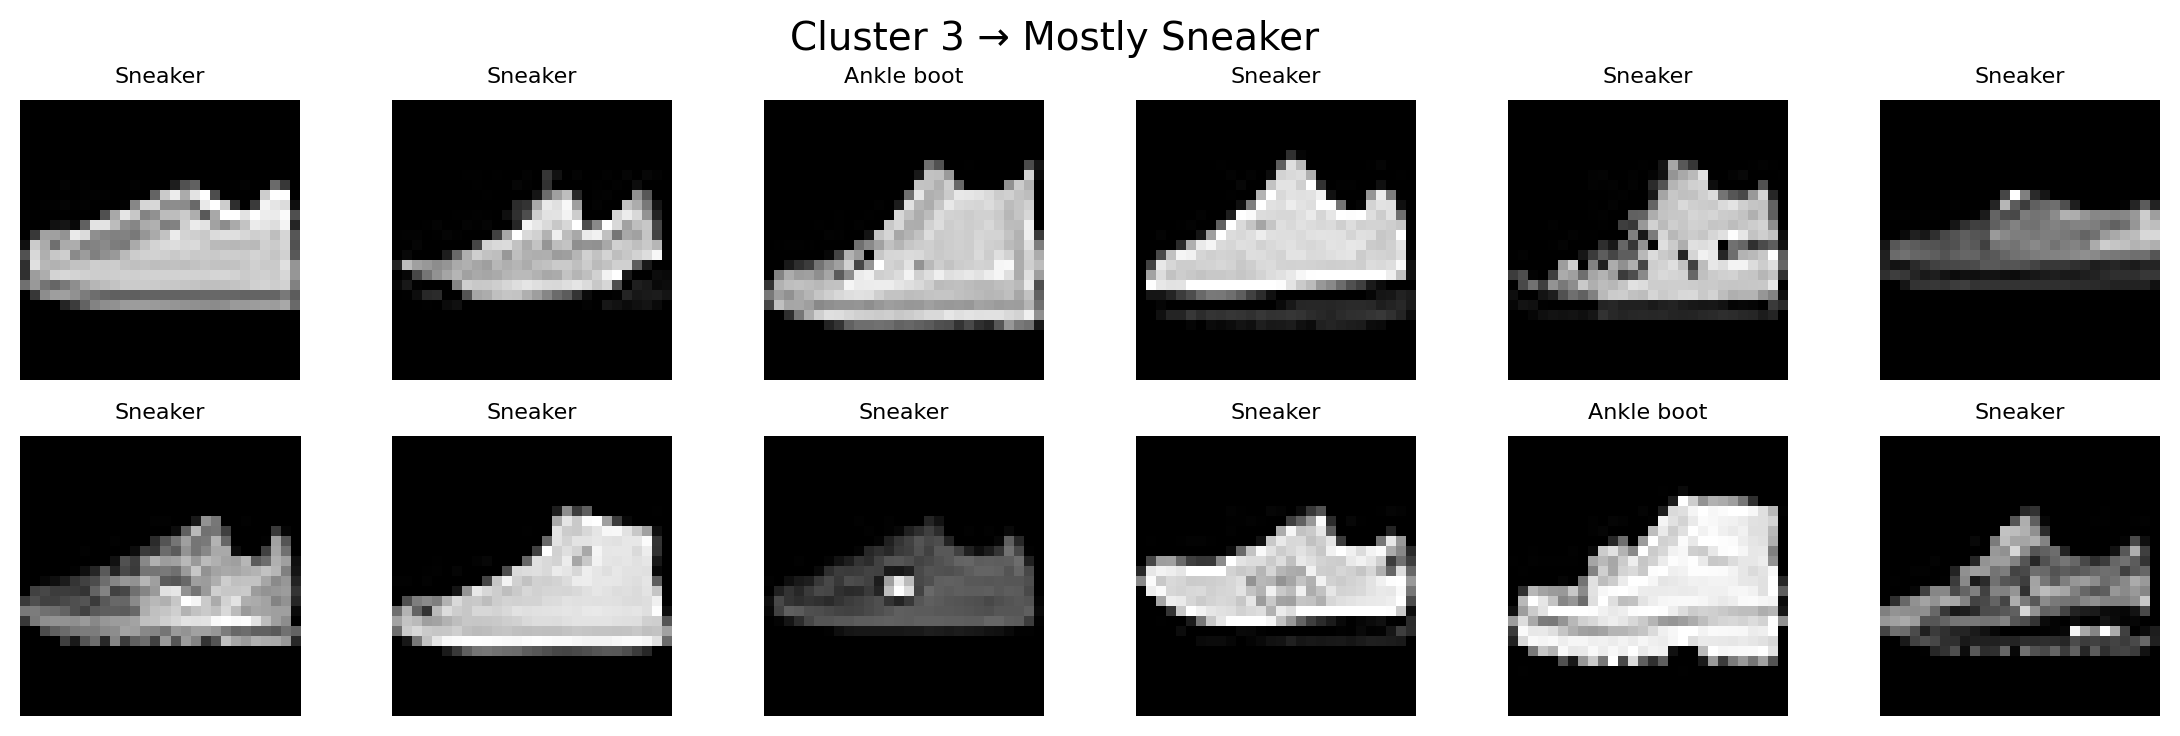

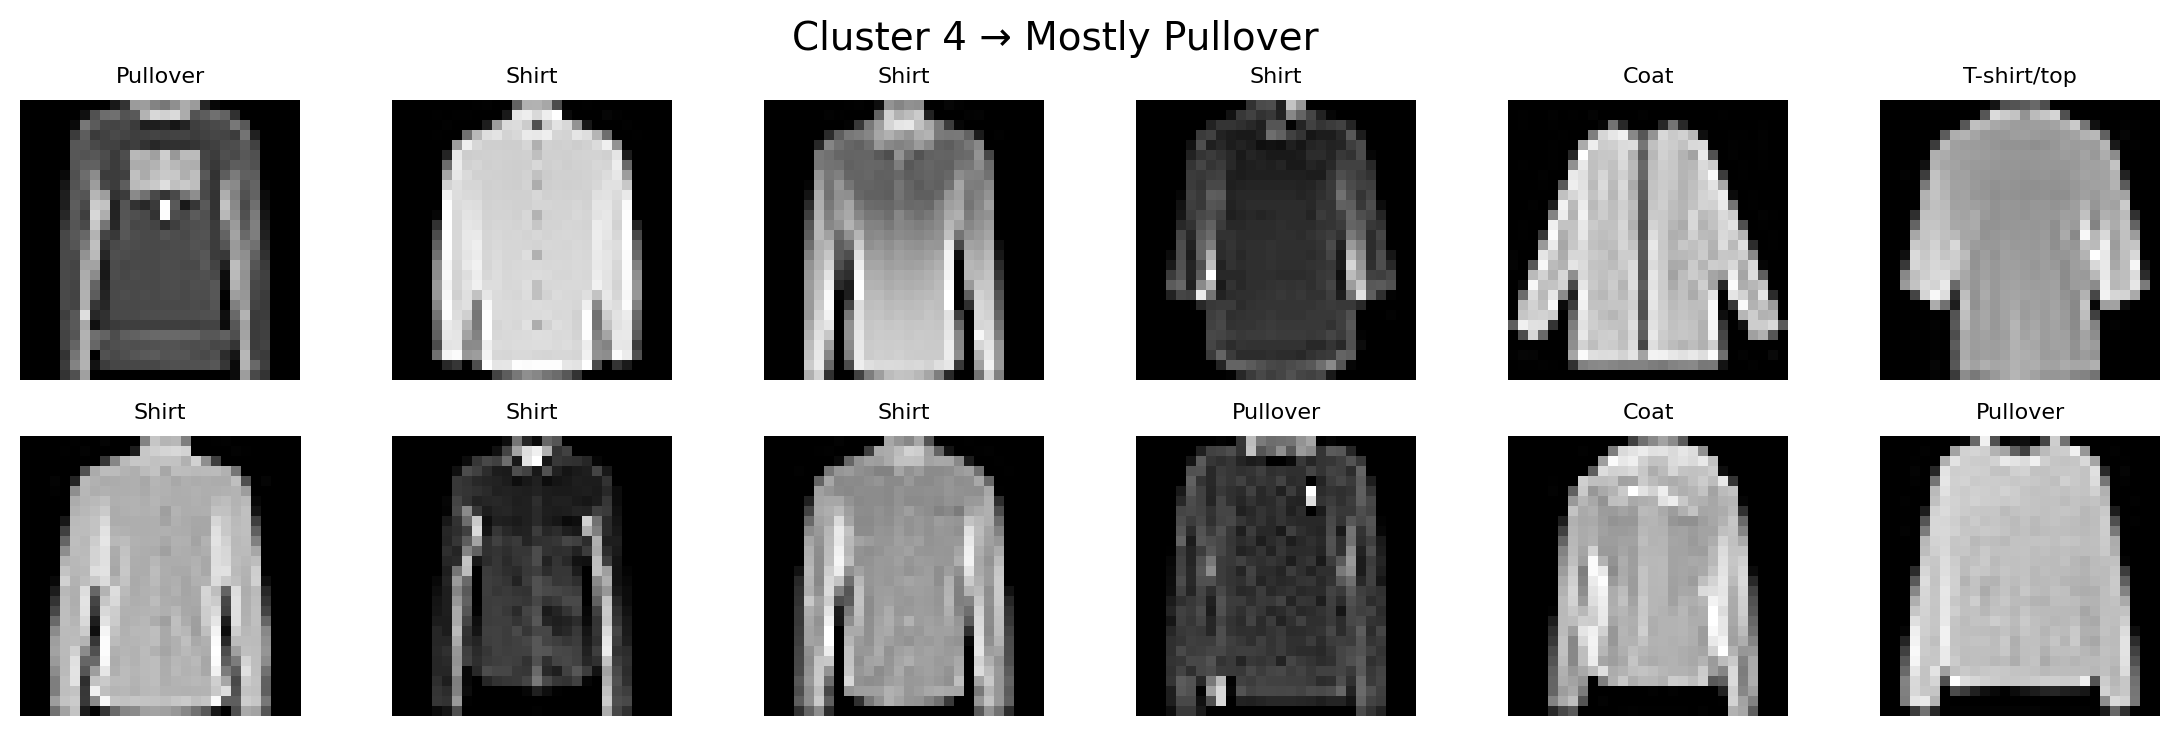

In [10]:
# Cell 7 — Show cluster images
def show_cluster_samples(cluster_id, n=12):
    idx = np.where(clusters == cluster_id)[0]
    if len(idx) == 0:
        print("Cluster", cluster_id, "is empty")
        return
    sel = np.random.choice(idx, size=min(n, len(idx)), replace=False)
    cols = 6
    rows = math.ceil(len(sel)/cols)

    plt.figure(figsize=(14, 2*rows), dpi=200)
    for i, s in enumerate(sel):
        plt.subplot(rows, cols, i+1)
        plt.imshow(x[s], cmap='gray', interpolation='nearest')
        plt.title(label_names[y[s]], fontsize=8)
        plt.axis('off')

    majority_label = np.bincount(y[idx]).argmax()
    plt.suptitle(f"Cluster {cluster_id} → Mostly {label_names[majority_label]}", fontsize=14)
    plt.show()

for c in range(min(K_CLUSTERS, 5)):  # show first 5 clusters
    show_cluster_samples(c, n=12)

**Model Comparison Summary**

Model Performance Comparison

Compares the results of all three models:

Logistic Regression (Accuracy ~71%)

Elastic Net (Accuracy ~75%)

CNN + PCA + KMeans (ARI/NMI clustering scores)
Displays results in a summary table for easy interpretation.

In [11]:
# Cell 8 — Compare Models
results = {
    "Logistic Regression (Accuracy)": acc_log,
    "Elastic Net (Accuracy)": acc_en,
    "CNN + PCA + KMeans (ARI)": ari,
    "CNN + PCA + KMeans (NMI)": nmi
}
results_df = pd.DataFrame(results.items(), columns=["Model", "Score"])
print(results_df)

                            Model     Score
0  Logistic Regression (Accuracy)  0.920500
1          Elastic Net (Accuracy)  0.913600
2        CNN + PCA + KMeans (ARI)  0.498429
3        CNN + PCA + KMeans (NMI)  0.628338
